In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform

In [27]:
df= pd.read_csv("C:/Users/user5/Downloads/bank_data.csv", sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [28]:
print(df.head(3))

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  

[3 rows x 21 columns]


In [29]:
possible_targets = ['y', 'deposit', 'subscribed']
target = None
for c in possible_targets:
    if c in df.columns:
        target = c
        break
if target is None:
    raise ValueError("Couldn't find target column. Expected one of: 'y', 'deposit', 'subscribed'.")


In [30]:
y_raw = df[target].astype(str).str.strip().str.lower()
if set(y_raw.unique()) <= {'yes', 'no'}:
    df[target] = y_raw.map({'no': 0, 'yes': 1}).astype(int)
else:
    df[target], _ = pd.factorize(df[target])
print("Target distribution:")
print(df[target].value_counts(normalize=True).rename('proportion').round(3))
if 'duration' in df.columns:
    df = df.drop(columns=['duration'])

Target distribution:
y
0    0.887
1    0.113
Name: proportion, dtype: float64


In [31]:
X = df.drop(columns=[target])
y = df[target].copy()
numeric_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()
print(f"Numeric features ({len(numeric_features)}):", numeric_features[:10], "..." if len(numeric_features)>10 else "")
print(f"Categorical features ({len(categorical_features)}):", categorical_features[:10], "..." if len(categorical_features)>10 else "")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Numeric features (9): ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'] 
Categorical features (10): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'] 


In [32]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='drop'
)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
pipe = Pipeline(steps=[('preprocess', preprocess),
('model', rf)])

In [33]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [34]:
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test ROC-AUC : {auc:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))


Test Accuracy: 0.8949
Test ROC-AUC : 0.7831

Classification Report:
               precision    recall  f1-score   support

           0     0.9144    0.9726    0.9426      7310
           1     0.5671    0.2823    0.3770       928

    accuracy                         0.8949      8238
   macro avg     0.7407    0.6275    0.6598      8238
weighted avg     0.8752    0.8949    0.8789      8238



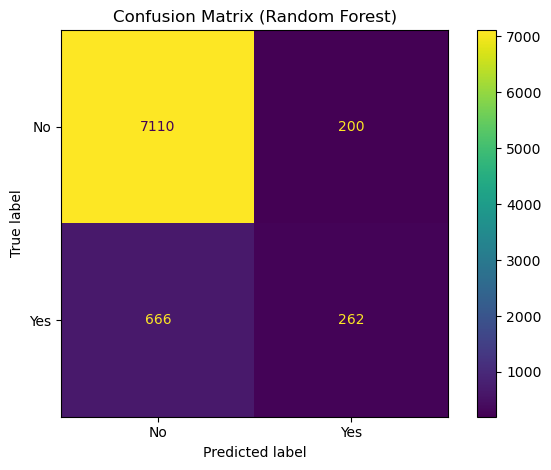

In [35]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(values_format='d')
plt.title("Confusion Matrix (Random Forest)")
plt.tight_layout()
plt.show()

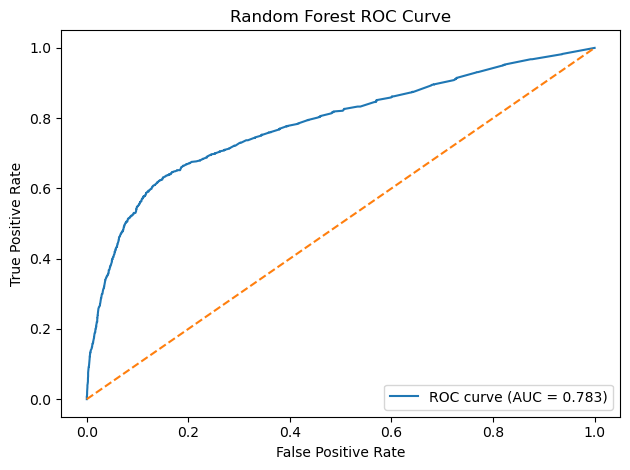

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

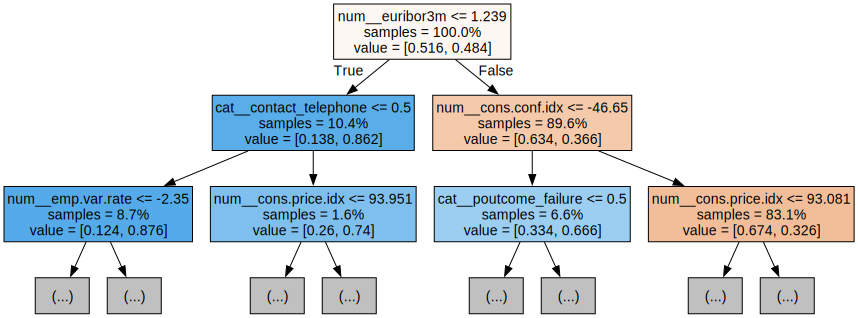

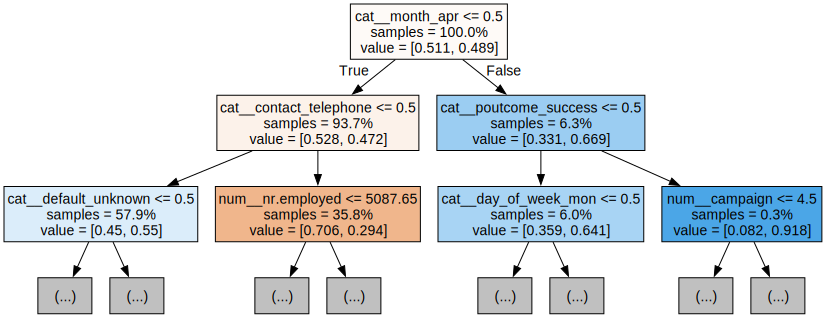

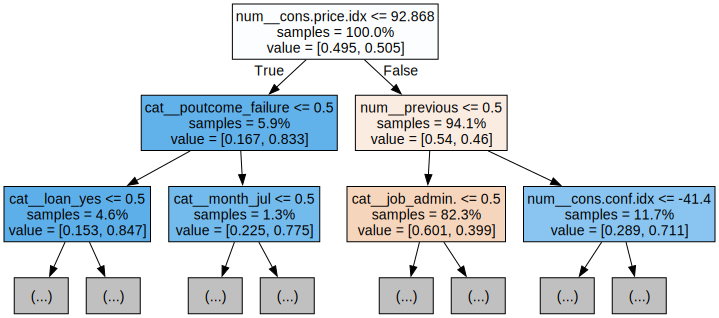

In [37]:
from sklearn.tree import export_graphviz
from IPython.display import display
import graphviz

import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"
# Get feature names after preprocessing
feature_names = pipe.named_steps['preprocess'].get_feature_names_out()

for i in range(3):
    tree = pipe.named_steps['model'].estimators_[i]
    dot_data = export_graphviz(
        tree,
        feature_names=feature_names,
        filled=True,
        max_depth=2,
        impurity=False,
        proportion=True
    )
    graph = graphviz.Source(dot_data)
    display(graph)